In [51]:
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from tqdm import tqdm
from mendeleev.fetch import fetch_table
from seaborn_fig2grid import SeabornFig2Grid
import matplotlib.gridspec as gridspec
import matplotlib


sns.set_style('whitegrid')
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"

%matplotlib inline

sys.path.append(str(Path().resolve().parent))
op = Path("plots/proxy_loss/ic/")
op.mkdir(parents=True, exist_ok=True)

In [52]:
# DIVYA:
val_data_path = "/home/minion/Downloads/ic_data/nrcc_ionic_conductivity"

# Mila:
# val_data_path = "/network/scratch/s/schmidtv/crystals-proxys/data/materials_dataset_v3/data/matbench_mp_e_form"

In [53]:
from dave import prepare_for_gfn

In [54]:
elements = fetch_table("elements")
elements = elements.set_index("atomic_number").drop(
    [c for c in elements.columns if c not in {"symbol", "atomic_number"}], axis=1
)


def to_formula(comp_tensor):
    mask = torch.nonzero(comp_tensor)
    counts = comp_tensor[mask].numpy().ravel()
    symbols = elements.loc[mask.numpy().ravel()].symbol
    return "".join([f"{s}{c}" for s, c in zip(symbols, counts)])

In [61]:

torch.set_grad_enabled(False)

print("Loading dave model")
model, loaders, scales = prepare_for_gfn(
    release="2.0.0",
    # ckpt_path_dict={"mila": "/network/scratch/s/schmidtv/crystals-proxys/proxy-ckpts/"},
    ckpt_path_dict="/home/minion/Downloads/ActiveLearningMaterials/checkpoints/58ac9c78/checkpoints-64d2be6a/epoch=0-step=550-total_val_mae=1.3665.ckpt",
    rescale_outputs=False,
    config_overrides={
        "src": val_data_path,
        # "model": {"concat": True}
})
#  if "minion" in val_data_path else {}
print(list(model.state_dict().keys()))
print("Lattice parameters are standardized with:", scales["x"])
print("Energy prediction de-normalization stats:", scales["y"])

def denorm_y(y):
    return y * scales["y"]["std"] + scales["y"]["mean"]


def denorm_x(x):
    return x * scales["x"]["std"] + scales["x"]["mean"]

Loading dave model
  Making model...
{'src': '/home/minion/Downloads/ic_data/nrcc_ionic_conductivity', 'crossval': 5, 'target': 'Ionic conductivity (S cm-1)', 'scales': {'x': {'mean': tensor([ 8.8024,  8.7201, 12.5978, 90.3520, 91.1842, 99.7799]), 'std': tensor([ 2.8865,  3.0252,  6.0318,  2.8599,  5.5594, 14.3485])}, 'y': False}, 'comp_size': 83, 'lat_size': 6, 'alphabet': [1, 3, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 34, 35, 38, 39, 40, 41, 42, 47, 48, 49, 50, 51, 52, 53, 56, 57, 58, 59, 60, 62, 64, 68, 71, 72, 73, 74, 82], 'model': {'input_len': 119, 'hidden_channels': 384, 'num_layers': 4, 'concat': True}, 'optim': {'batch_size': 32, 'lr': 0.0017609629437883411, 'epochs': 50, 'es_patience': 5, 'scheduler': {'name': 'StepLR', 'patience': 4, 'step_size': 5000, 'decay_factor': 0.5}, 'num_workers': 12}, 'config': 'mlp-ic', 'wandb_run_name': '58ac9c78', 'wandb_project': 'Dave-IC', 'wandb_tags': '', 'wandb_entity': 'mila-ocp', 'wand

In [7]:
(comp, sg, lps), ic = next(iter(loaders["train"]))
# eform = denorm_y(ic)

In [62]:
df = []
for dataset in ["train"]:
    for batch in tqdm(loaders[dataset], desc=dataset):
        x, ic_log = batch
        comp, sg, lps = x
        pred_log = model(x)
        pred = torch.pow(10, pred_log)
        ic = torch.pow(10, ic_log)
        # pred = torch.exp(pred_log)
        # ic = torch.exp(ic_log)
        lps = denorm_x(lps)

        for b in range(len(comp)):
            df.append({
                "comp": comp[b].numpy(),
                "formula": to_formula(comp[b]),
                "sg": sg[b].item(),
                "lps": lps[b].numpy(),
                "a": lps[b][0].item(),
                "b": lps[b][1].item(),
                "c": lps[b][2].item(),
                "alpha": lps[b][3].item(),
                "beta": lps[b][4].item(),
                "gamma": lps[b][5].item(),
                "ic_log10": ic_log[b].item(),
                "ic": ic[b].item(),
                # "eform_normed": eform_normed[b].item(),
                # "eform": eform[b].item(),
                "pred_log10": pred_log[b].item(),
                "pred": pred[b].item(),
                "dataset": dataset
            })
df = pd.DataFrame(df)
df["mae"] = df.apply(lambda row: np.abs(row["ic"] - row["pred"]), axis=1)
df["mae_log"] = df.apply(lambda row: np.abs(row["ic_log10"] - row["pred_log10"]), axis=1)


train: 100%|██████████| 11/11 [00:00<00:00, 89.21it/s]


In [63]:
ref_df = pd.read_csv(Path(val_data_path) / "train_data.csv", usecols=range(10))
element_cols = list(ref_df.columns[8:102])
ref_df["formula"] = ref_df[element_cols].apply(
    lambda row: to_formula(
        torch.tensor(np.concatenate([np.array([0]), row.values.astype(int)]))
    ),
    axis=1,
)
ref_df[["formula", "a", "b", "c", "alpha", "beta", "gamma", "Ionic conductivity (S cm-1)"]].head()

,formula,a,b,c,alpha,beta,gamma,Ionic conductivity (S cm-1)
0,H90He-15,7.65545,8.53175,10.7894,90.0,90.00,90.0,-15.000000
1,H90He-5,12.82000,12.82000,12.8200,90.0,90.00,90.0,-5.576754
2,H90He-6,14.20100,8.38700,9.8610,90.0,94.07,90.0,-6.301030
3,H90He-3,12.96330,12.96330,12.9633,90.0,90.00,90.0,-3.677781
4,H120He-6,8.51300,8.51300,21.2290,90.0,90.00,120.0,-6.187087


In [64]:
df[df.dataset == "train"][["formula", "a", "b", "c", "alpha", "beta", "gamma", "ic", "pred", "ic_log10", "pred_log10"]].head()

,formula,a,b,c,alpha,beta,gamma,ic,pred,ic_log10,pred_log10
0,O6Ti2La1,3.8695,3.8695,7.7780,90.0,90.000000,90.0,4.120000e-04,1.674134e-04,-3.385103,-3.776210
1,Li32B56O96Cl8,12.1670,12.1670,12.1670,90.0,90.000000,90.0,2.000001e-06,2.059203e-07,-5.698970,-6.686301
2,Li6O72P18Ti11,8.5126,8.5126,20.9212,90.0,90.000000,120.0,2.599999e-04,1.975627e-04,-3.585027,-3.704295
3,Li7O72Si1P16Ti12,8.5180,8.5180,20.8480,90.0,90.000000,120.0,8.599997e-05,1.787182e-04,-4.065502,-3.747831
4,Li8O8Si1,5.1496,6.1771,5.3424,90.0,90.300003,90.0,2.019999e-08,6.669435e-10,-7.694649,-9.175911


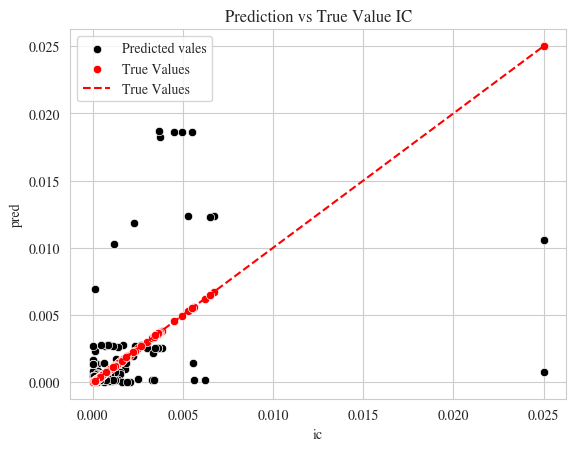

In [65]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sns.scatterplot(x="ic", y="pred", data=df, ax=ax, **{'color': 'k', 'label': 'Predicted vales'})
sns.scatterplot(x="ic", y="ic", data=df, ax=ax, **{'color': 'r', 'label': 'True Values', 'markers': 's'})
sns.lineplot(x="ic", y="ic", data=df, ax=ax, **{'color': 'r', 'label': 'True Values', 'linestyle': '--'})
plt.title("Prediction vs True Value IC")
plt.show()

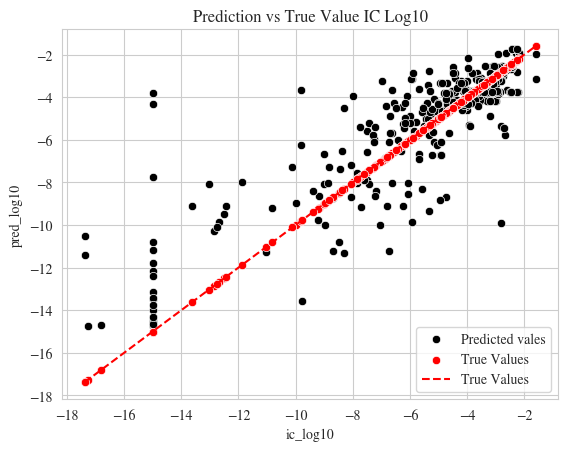

In [66]:
plt.figure()
sns.scatterplot(x="ic_log10", y="pred_log10", data=df, **{'color': 'k', 'label': 'Predicted vales'})
sns.scatterplot(x="ic_log10", y="ic_log10", data=df, **{'color': 'r', 'label': 'True Values'})
sns.lineplot(x="ic_log10", y="ic_log10", data=df, **{'color': 'r', 'label': 'True Values', 'linestyle': '--'})
plt.title("Prediction vs True Value IC Log10")
plt.show()

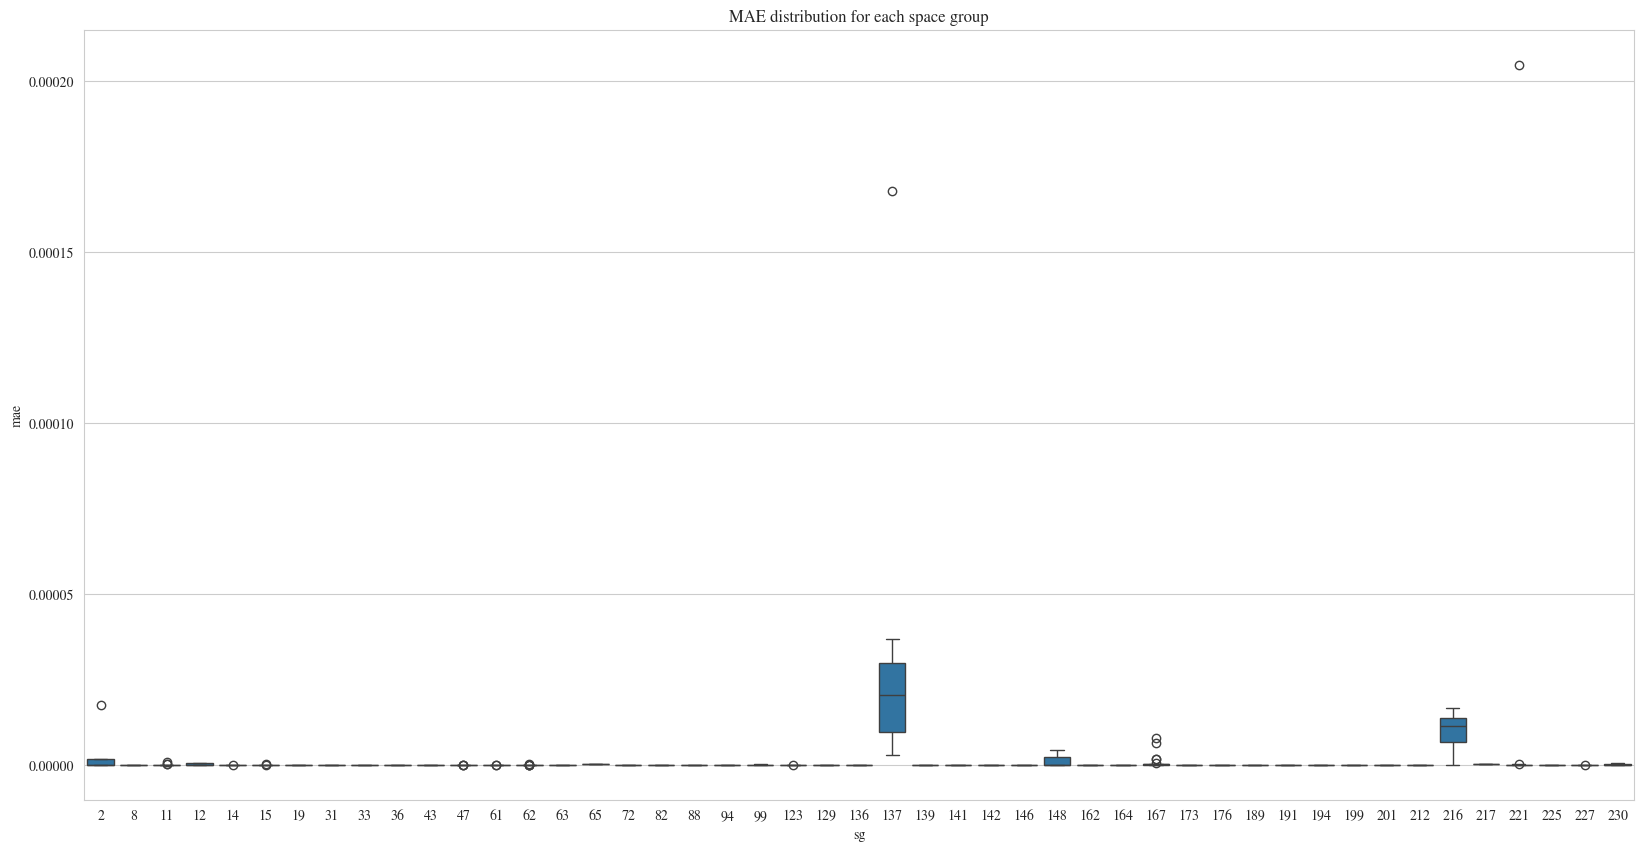

In [9]:
# boxplot of the MAE distribution for each space group
plt.figure(figsize=(20, 10))
sns.boxplot(x="sg", y="mae", data=df)
plt.title("MAE distribution for each space group")
plt.show()

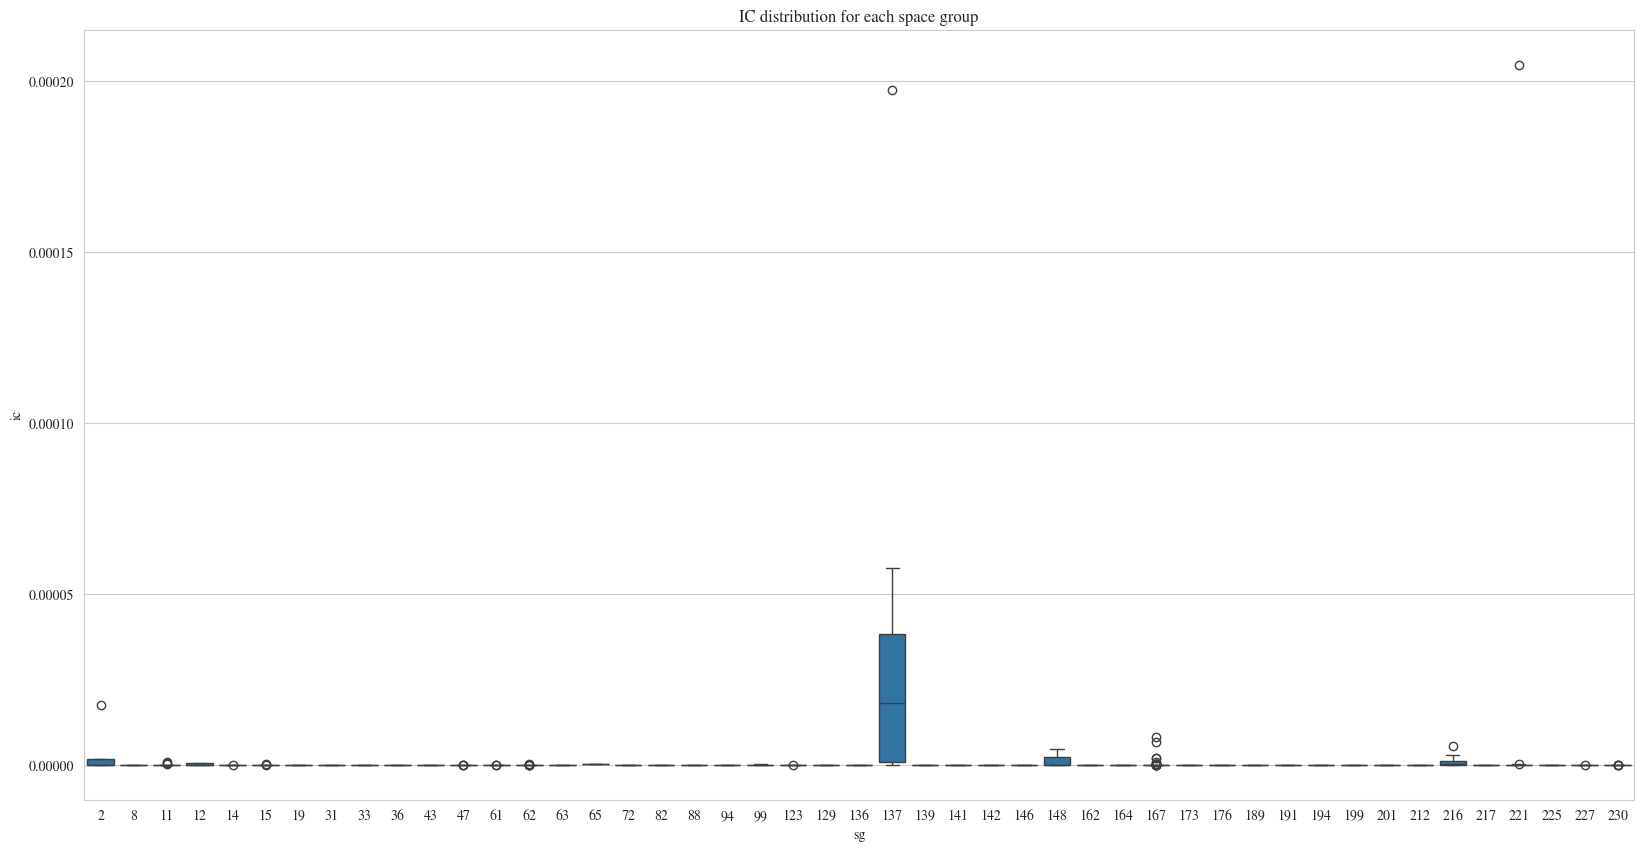

In [10]:
# boxplot of the MAE distribution for each space group
plt.figure(figsize=(20, 10))
sns.boxplot(x="sg", y="ic", data=df)
plt.title("IC distribution for each space group")
plt.show()

In [11]:
stats = df[["sg", "mae", "ic"]].groupby("sg").describe()
stats

mae                                                          \
    count          mean           std           min           25%   
sg                                                                  
2     5.0  3.867920e-06  7.682082e-06  6.242647e-23  2.463546e-22   
8     1.0  3.144807e-20           NaN  3.144807e-20  3.144807e-20   
11   12.0  1.307388e-07  2.381968e-07  1.040546e-16  2.892125e-16   
12    5.0  2.387806e-07  3.282842e-07  5.869022e-17  7.848676e-16   
14    6.0  1.859078e-13  4.506230e-13  8.308548e-26  1.639339e-17   
15   11.0  3.734867e-08  1.095248e-07  7.878445e-24  5.132072e-21   
19    1.0  2.995372e-22           NaN  2.995372e-22  2.995372e-22   
31    3.0  1.117704e-15  1.934462e-15  7.806872e-19  8.415668e-19   
33    2.0  1.285163e-19  1.816332e-19  8.225181e-23  6.429927e-20   
36    2.0  3.639953e-14  5.147656e-14  9.834971e-20  1.819981e-14   
43    1.0  1.224476e-11           NaN  1.224476e-11  1.224476e-11   
47   12.0  9.550835e-09  2.470633e-08  2.198155e-15  2.797415e-13   
61    9.0  2.808704e-12  5.761662e-12  3.824492e-22  9.776184e-14   
62   24.0  1.119683e-08  5.477483e-08  1.123076e-26  4.078053e-22   
63    1.0  1.439056e-22           NaN  1.439056e-22  1.439056e-22   
65    1.0  3.649625e-07           NaN  3.649625e-07  3.649625e-07   
72    1.0  8.208224e-18           NaN  8.208224e-18  8.208224e-18   
82    2.0  1.367058e-10  4.809285e-11  1.026990e-10  1.197024e-10   
88    2.0  3.410810e-19  4.527569e-19  2.093351e-20  1.810072e-19   
94    1.0  2.970202e-13           NaN  2.970202e-13  2.970202e-13   
99    7.0  6.469756e-08  5.657715e-08  6.812935e-10  2.182941e-08   
123  11.0  3.185302e-08  3.318246e-08  2.365730e-15  6.131429e-09   
129   3.0  1.977961e-12  2.416074e-12  5.448544e-17  6.315269e-13   
136   1.0  2.415756e-22           NaN  2.415756e-22  2.415756e-22   
137  22.0  2.716538e-05  3.325552e-05  2.912187e-06  9.768434e-06   
139   2.0  1.755325e-25  7.732370e-26  1.208564e-25  1.481945e-25   
141   2.0  1.631521e-20  1.506619e-20  5.661800e-21  1.098850e-20   
142   1.0  3.296785e-12           NaN  3.296785e-12  3.296785e-12   
146   1.0  3.759074e-26           NaN  3.759074e-26  3.759074e-26   
148   3.0  1.548722e-06  2.572611e-06  7.349202e-14  6.388253e-08   
162   2.0  1.647621e-09  6.911415e-10  1.158910e-09  1.403265e-09   
164   3.0  1.020500e-08  1.697045e-08  1.737065e-10  4.080398e-10   
167  94.0  3.346247e-07  1.055481e-06  1.151556e-11  5.996718e-09   
173   1.0  2.730800e-30           NaN  2.730800e-30  2.730800e-30   
176   1.0  5.221168e-28           NaN  5.221168e-28  5.221168e-28   
189   1.0  1.015162e-29           NaN  1.015162e-29  1.015162e-29   
191   1.0  3.478558e-08           NaN  3.478558e-08  3.478558e-08   
194   2.0  2.911254e-08  3.647380e-08  3.321667e-09  1.621710e-08   
199   2.0  2.606232e-11  3.553101e-11  9.381001e-13  1.350021e-11   
201   1.0  7.680994e-19           NaN  7.680994e-19  7.680994e-19   
212   3.0  5.466174e-26  9.466473e-26  1.890489e-30  7.031812e-30   
216  41.0  1.000523e-05  4.901948e-06  4.777718e-22  6.697398e-06   
217   1.0  2.652259e-07           NaN  2.652259e-07  2.652259e-07   
221  18.0  1.143070e-05  4.823240e-05  1.539479e-09  2.448285e-09   
225   1.0  7.341912e-10           NaN  7.341912e-10  7.341912e-10   
227   4.0  1.313619e-09  2.624668e-09  9.289492e-14  4.098511e-13   
230  33.0  1.333242e-07  1.969940e-07  1.641510e-29  1.274411e-11   

                                                 ic                \
              50%           75%           max count          mean   
sg                                                                  
2    2.541993e-22  1.800509e-06  1.753909e-05   5.0  3.867920e-06   
8    3.144807e-20  3.144807e-20  3.144807e-20   1.0  4.342207e-20   
11   1.144329e-08  1.114918e-07  7.404249e-07  12.0  1.347044e-07   
12   8.945841e-14  5.553537e-07  6.385492e-07   5.0  2.387806e-07   
14   1.942894e-16  7.094304e-15  1.105707e-12   6.0  2.276479e-13   
15 

Text(0.5, 1.0, 'Space Group histogram')

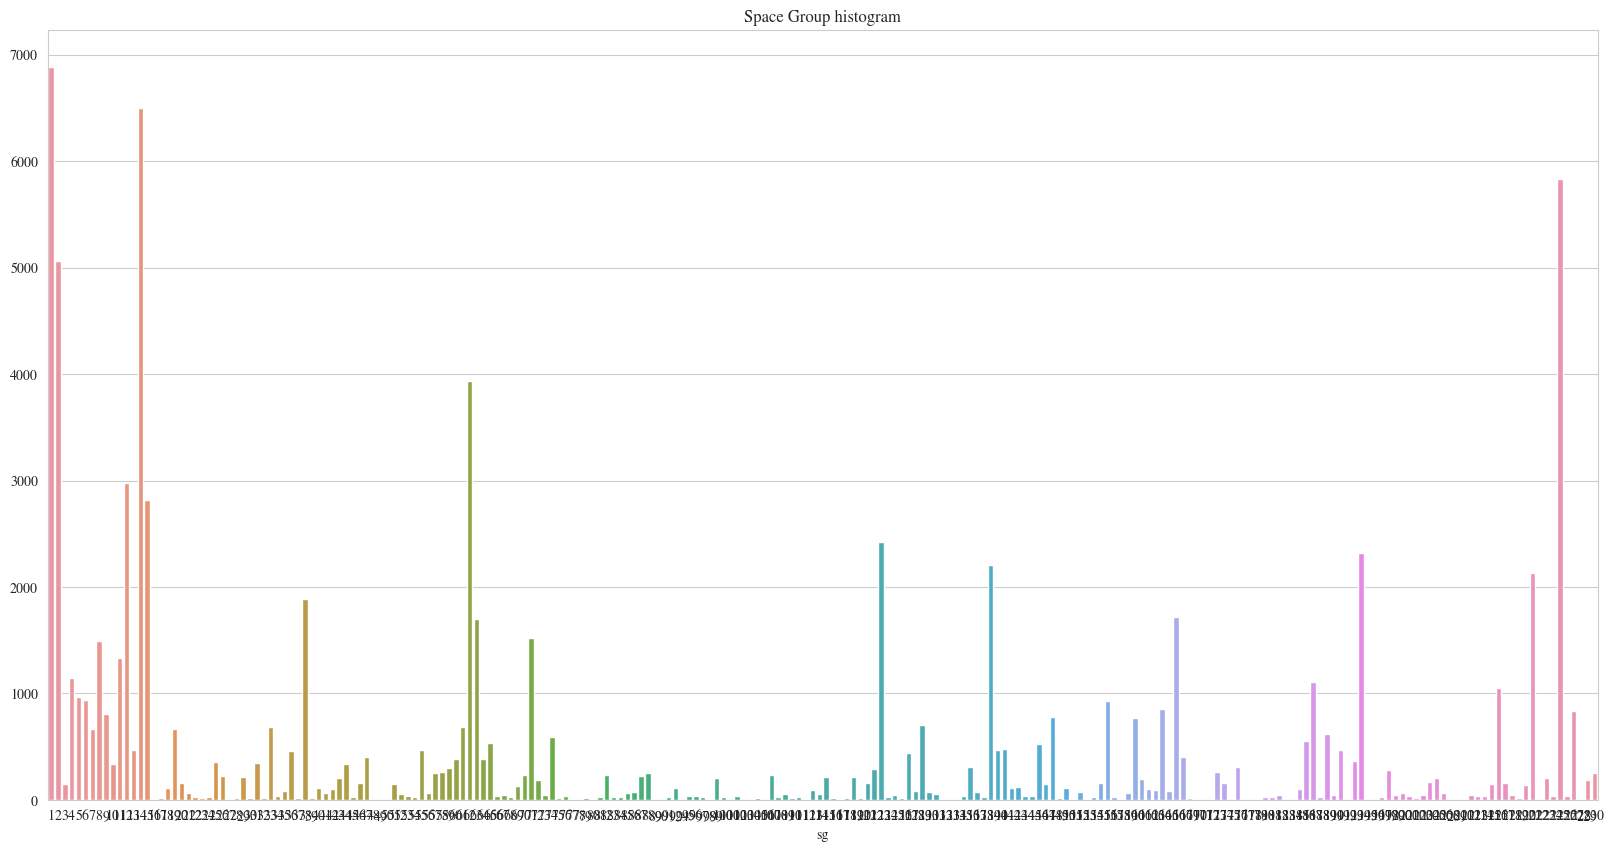

In [30]:
plt.figure(figsize=(20, 10))
sns.barplot(x=stats["mae"]["count"].index, y=stats["mae"]["count"].values)
plt.title("Space Group histogram")

In [31]:
mask = stats["eform"]["75%"] > 0
sg_pos = set(mask[mask].index)
print("Selecting space groups with Formation Energy 75% quantile > 0:", sg_pos, f"(n={mask.sum()})")

Selecting space groups with Formation Energy 75% quantile > 0: {194, 228, 38, 71, 104, 139, 216, 187} (n=8)


In [32]:
# boxplot of the MAE distribution for each space group
double_df = df.copy()
double_df["sg"] = "all"
double_df = pd.concat([df.copy(), double_df])

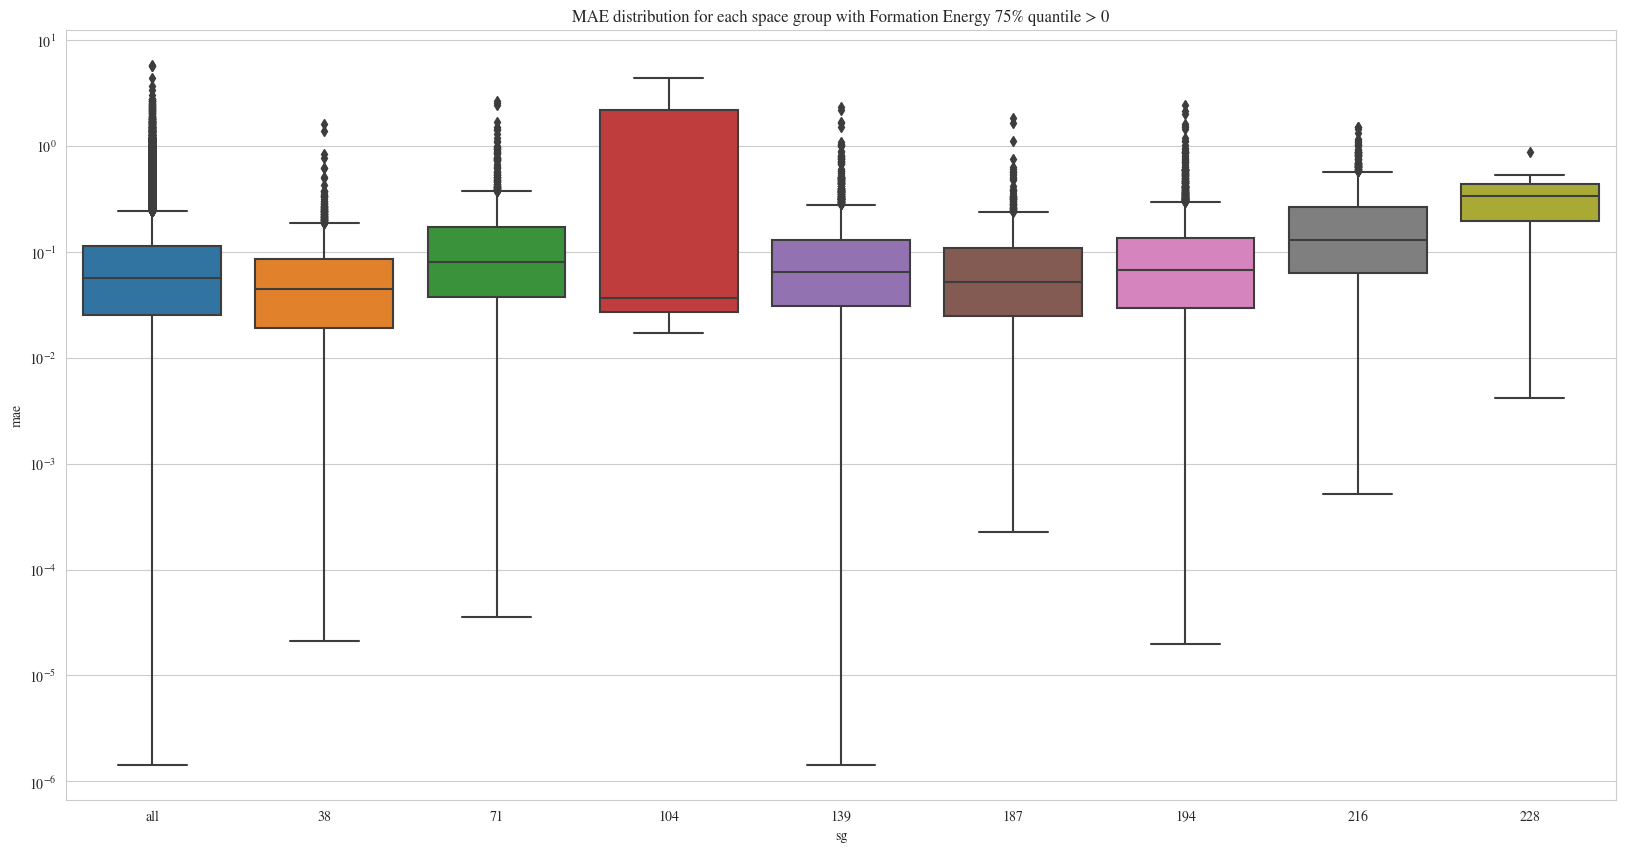

In [33]:
plt.figure(figsize=(20, 10))
sns.boxplot(x="sg", y="mae", data=double_df[double_df["sg"].isin(sg_pos | set(["all"]))], order=["all"] + sorted(sg_pos))
plt.title("MAE distribution for each space group with Formation Energy 75% quantile > 0")
plt.yscale("log")
plt.show()

/tmp/ipykernel_23427/1243351713.py:5: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[0].set_ylim(0, 1200)


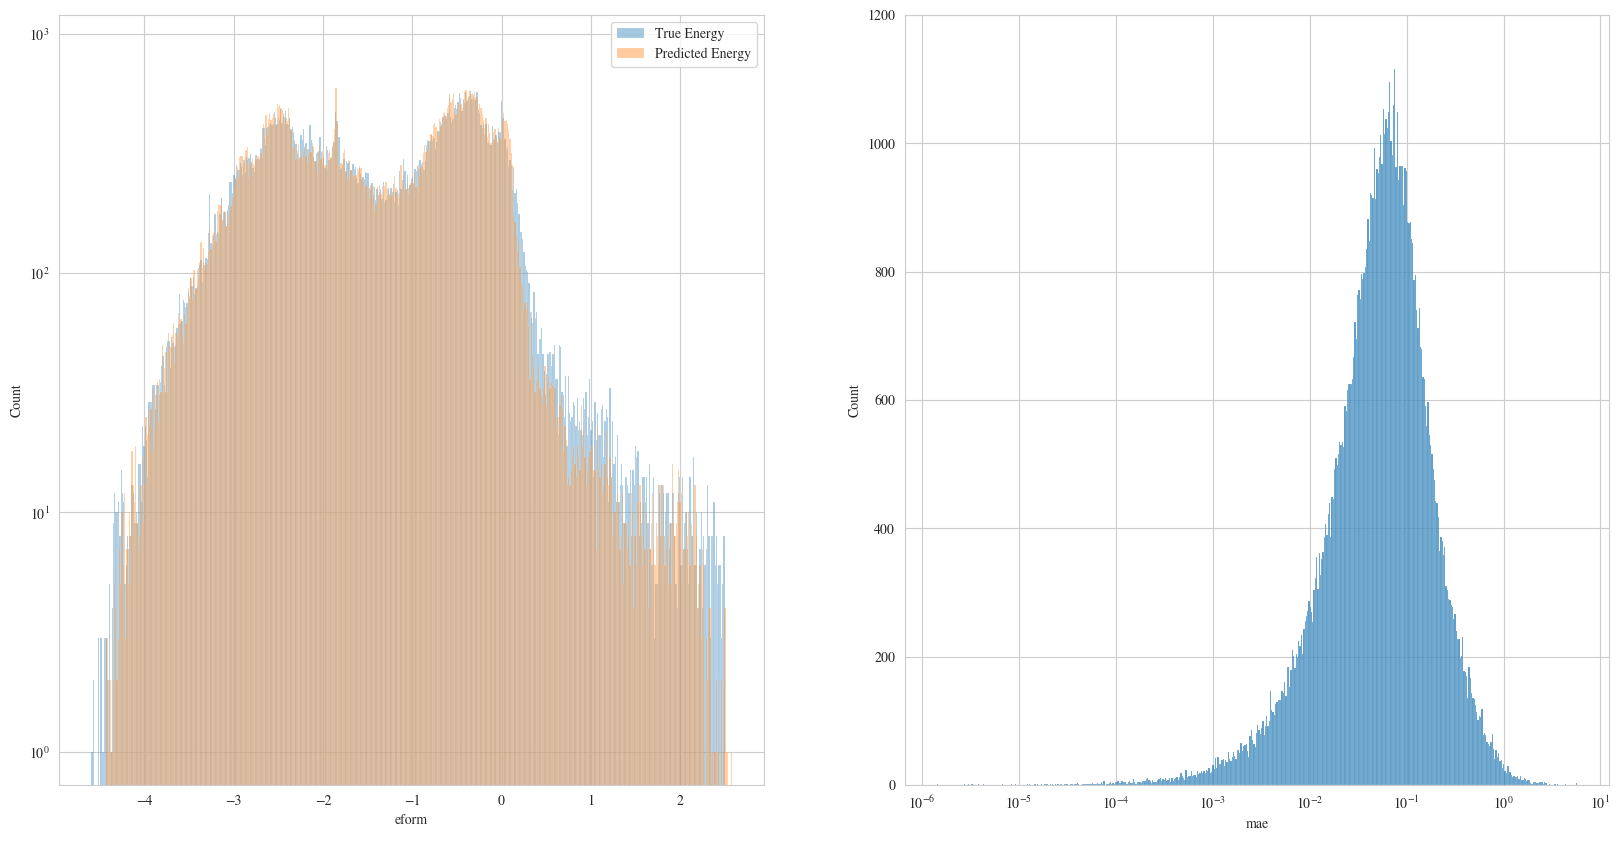

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
sns.histplot(df["eform"], bins=500, log_scale=(False, True), ax=axs[0], label="True Energy", alpha=0.4)
sns.histplot(df["pred"], bins=500, log_scale=(False, True), ax=axs[0], label="Predicted Energy", alpha=0.4)
sns.histplot(df["mae"], label="MAE", bins=500, log_scale=(True, False), ax=axs[1])
axs[0].set_ylim(0, 1200)
axs[1].set_ylim(0, 1200)
axs[0].legend()

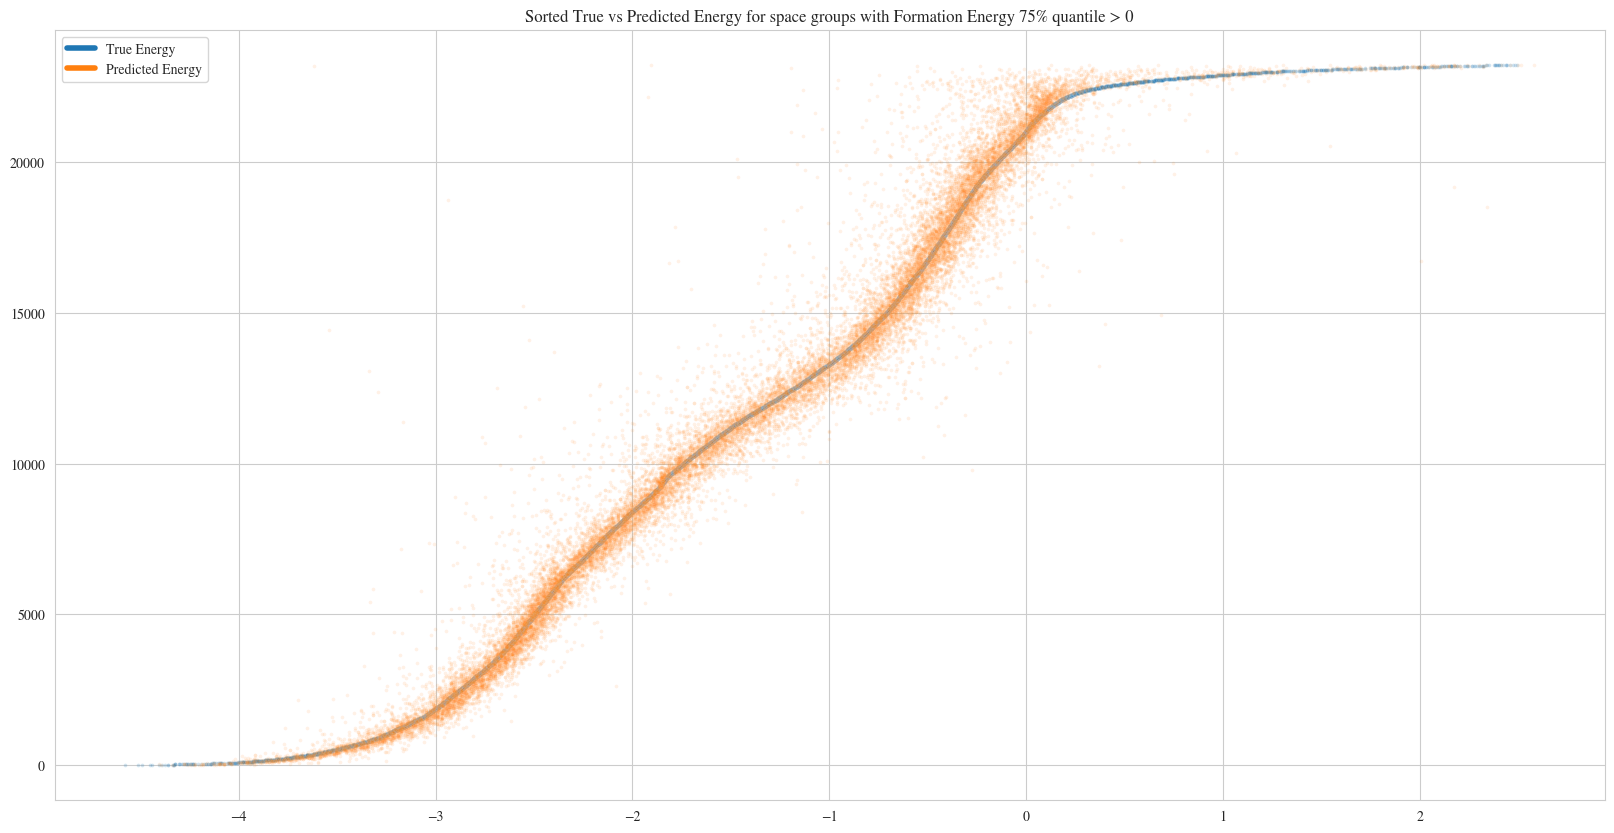

In [35]:
# sorted_df = df[(df.dataset == "val") & (df.sg.isin(sg_pos))]
sorted_df = df[(df.dataset == "val")]
sort_idx = np.argsort(sorted_df["eform"].values)
plt.figure(figsize=(20, 10))
sns.scatterplot(
    y=np.arange(len(sorted_df)),
    x=sorted_df["eform"].values[sort_idx],
    label="True Energy",
    alpha=0.2,
    s=7,
)
sns.scatterplot(
    y=np.arange(len(sorted_df)),
    x=sorted_df["pred"].values[sort_idx],
    label="Predicted Energy",
    alpha=0.1,
    s=7,
    color="C1",
)
# sns.scatterplot(
#     x=np.arange(len(sorted_df)),
#     y=sorted_df["mae"].values[sort_idx],
#     label="MAE",
#     alpha=0.3,
#     s=10,
#     color="C4",
# )
plt.title("Sorted True vs Predicted Energy for space groups with Formation Energy 75% quantile > 0")
plt.legend(
    handles=[
        plt.Line2D([0], [0], color="C0", lw=4, label="True Energy"),
        plt.Line2D([0], [0], color="C1", lw=4, label="Predicted Energy"),
        # plt.Line2D([0], [0], color="C4", lw=4, label="MAE"),
    ],
)

/tmp/ipykernel_23427/2223516214.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bdf.loc[:, "eform_bin"] = np.digitize(bdf["eform"], eform_bins) - 1


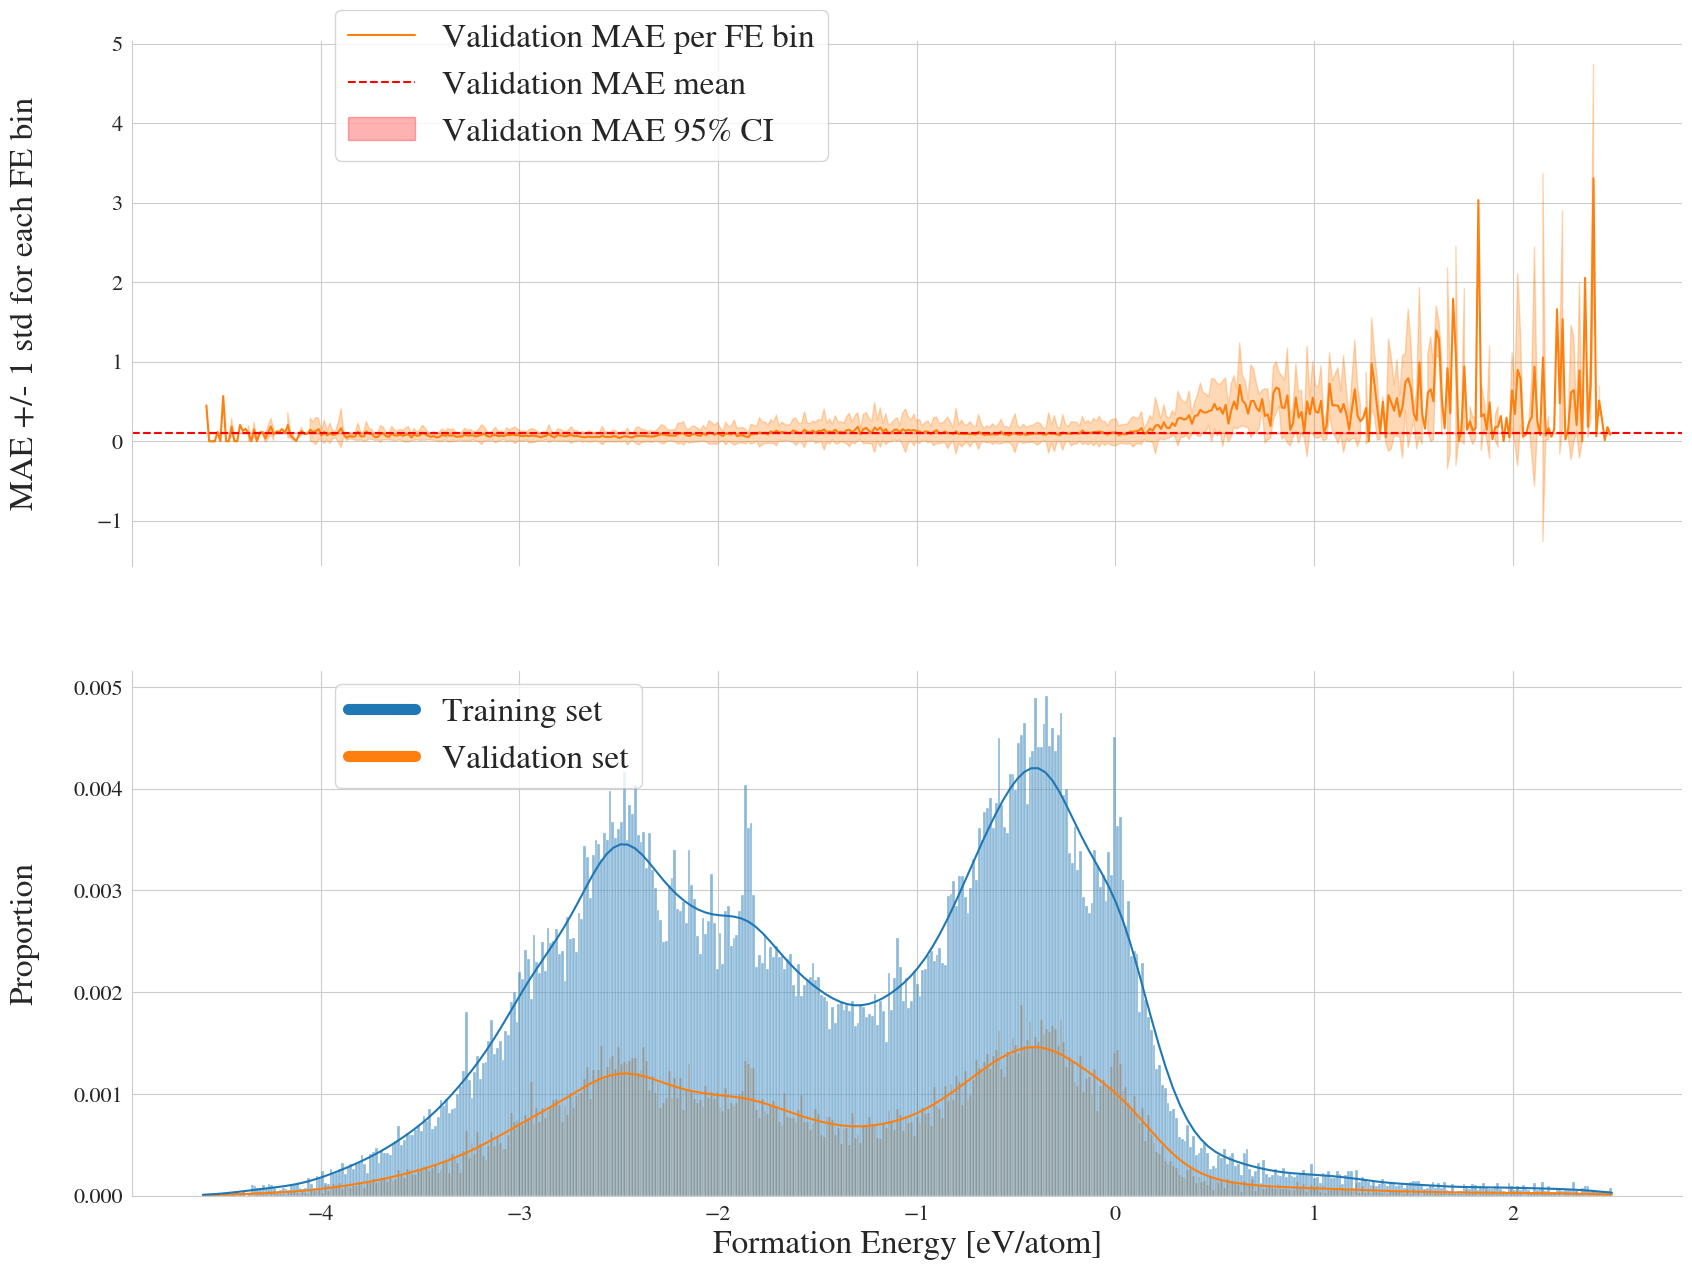

In [36]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
# bins eform and mae and then plot the distribution of mae for each bin
# with shaded area for 1 std around the mean
nbins = 500
bdf = df[(df.dataset == "val")]
fdf = df.copy()
fdf["Data set split"] = fdf["dataset"]

eform_bins = np.linspace(bdf["eform"].min(), bdf["eform"].max(), nbins + 1)
bdf.loc[:, "eform_bin"] = np.digitize(bdf["eform"], eform_bins) - 1

eform_bin_mae_mean = bdf.groupby("eform_bin")["mae"].mean()
tmp = np.zeros(nbins + 1)
tmp[eform_bin_mae_mean.index] = eform_bin_mae_mean.values
eform_bin_mae_mean = tmp

eform_bin_mae_std = bdf.groupby("eform_bin")["mae"].std()
tmp = np.zeros(nbins + 1)
tmp[eform_bin_mae_std.index] = eform_bin_mae_std.values
eform_bin_mae_std = tmp

eform_bin_count = bdf.groupby("eform_bin")["mae"].count()
tmp = np.zeros(nbins + 1)
tmp[eform_bin_count.index] = eform_bin_count.values
eform_bin_count = tmp
eform_bin_count = eform_bin_count / eform_bin_count.sum()


fig, ax = plt.subplots(2, 1, figsize=(20, 15), sharex=True,)
ax[0].plot(eform_bins, eform_bin_mae_mean, color="C1", label="Validation MAE per FE bin")
ax[0].fill_between(
    eform_bins,
    eform_bin_mae_mean - eform_bin_mae_std,
    eform_bin_mae_mean + eform_bin_mae_std,
    alpha=0.3,
    color="C1",
)
m, s = bdf["mae"].agg(["mean", "sem"])
ax[0].axhline(m, color="red", linestyle="--", label="Validation MAE mean")
ax[0].fill_between(
    eform_bins,
    m - 1.96 * s,
    m + 1.96 * s,
    alpha=0.3,
    color="red",
    label="Validation MAE 95% CI",
)
ax[0].legend(frameon=True, bbox_to_anchor=(0.12, 0.915), loc="center left", fontsize=24)

ax[0].set_ylabel("MAE +/- 1 std for each FE bin", fontsize=24)
sns.histplot(
    data=fdf,
    x="eform",
    hue="Data set split",
    bins=500,
    ax=ax[1],
    kde=True,
    stat="proportion",
    legend=True,
)
ax[1].set_xlabel("Formation Energy [eV/atom]", fontsize=24)
ax[1].set_ylabel("Proportion", fontsize=24)
# manual legend for hist plot
ax[1].legend(
    handles=[
        plt.Line2D([0], [0], color="C0", lw=8, label="Training set"),
        plt.Line2D([0], [0], color="C1", lw=8, label="Validation set"),
    ],
    frameon=True,
    bbox_to_anchor=(0.12, 0.875), loc="center left",
    fontsize=24,
)
sns.despine(ax=ax[0], top=True, right=True, bottom=True, left=False)
sns.despine(ax=ax[1], top=True, right=True, bottom=False, left=False)
# plt.tight_layout()
# aligning ylabels to the right from both axs:
ax[0].yaxis.set_label_coords(-0.06, 0.5)
ax[1].yaxis.set_label_coords(-0.06, 0.5)

plt.savefig(op / "mae-dist.pdf")


In [37]:
print(bdf["mae"].mean())
print(bdf["mae"].std())
print(bdf[bdf["eform"] < 0]["mae"].mean())
print(bdf[bdf["eform"] < 0]["mae"].std())

0.10430406736204857
0.16556866176700197
0.0901243419812418
0.12372206447060512


In [38]:
stats = bdf["mae"].agg(['mean', 'sem'])
print(stats)
print('-'*30)


stats['ci95_hi'] = stats['mean'] + 1.96* stats['sem']
stats['ci95_lo'] = stats['mean'] - 1.96* stats['sem']
print(stats)
print(f"{stats['mean']:.3f} +/- {stats['sem']:.3f}")

mean    0.104304
sem     0.001086
Name: mae, dtype: float64
------------------------------
mean       0.104304
sem        0.001086
ci95_hi    0.106433
ci95_lo    0.102175
Name: mae, dtype: float64
0.104 +/- 0.001


In [39]:
import matplotlib.gridspec as gridspec


def joint_plot(
    df,
    x,
    y,
    scale_kwarg={},
    labels={
        "mae": "MAE (eV)",
        "eform": "Formation Energy (eV)",
        "sg": "Space Group",
    },
    figsize=(10, 10),
):
    plt.figure(figsize=figsize)
    g = sns.JointGrid(data=df, x=x, y=y, marginal_ticks=True)
    g.ax_joint.set(**scale_kwarg)
    g.plot_joint(
        sns.histplot,
        discrete=(False, False),
        pmax=0.8,
        bins=500,
        color="#7371Fd",
    )
    g.plot_marginals(sns.histplot, element="step", color="#7371Fd")
    g.set_axis_labels(xlabel=labels[x], ylabel=labels[y])
    return g

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

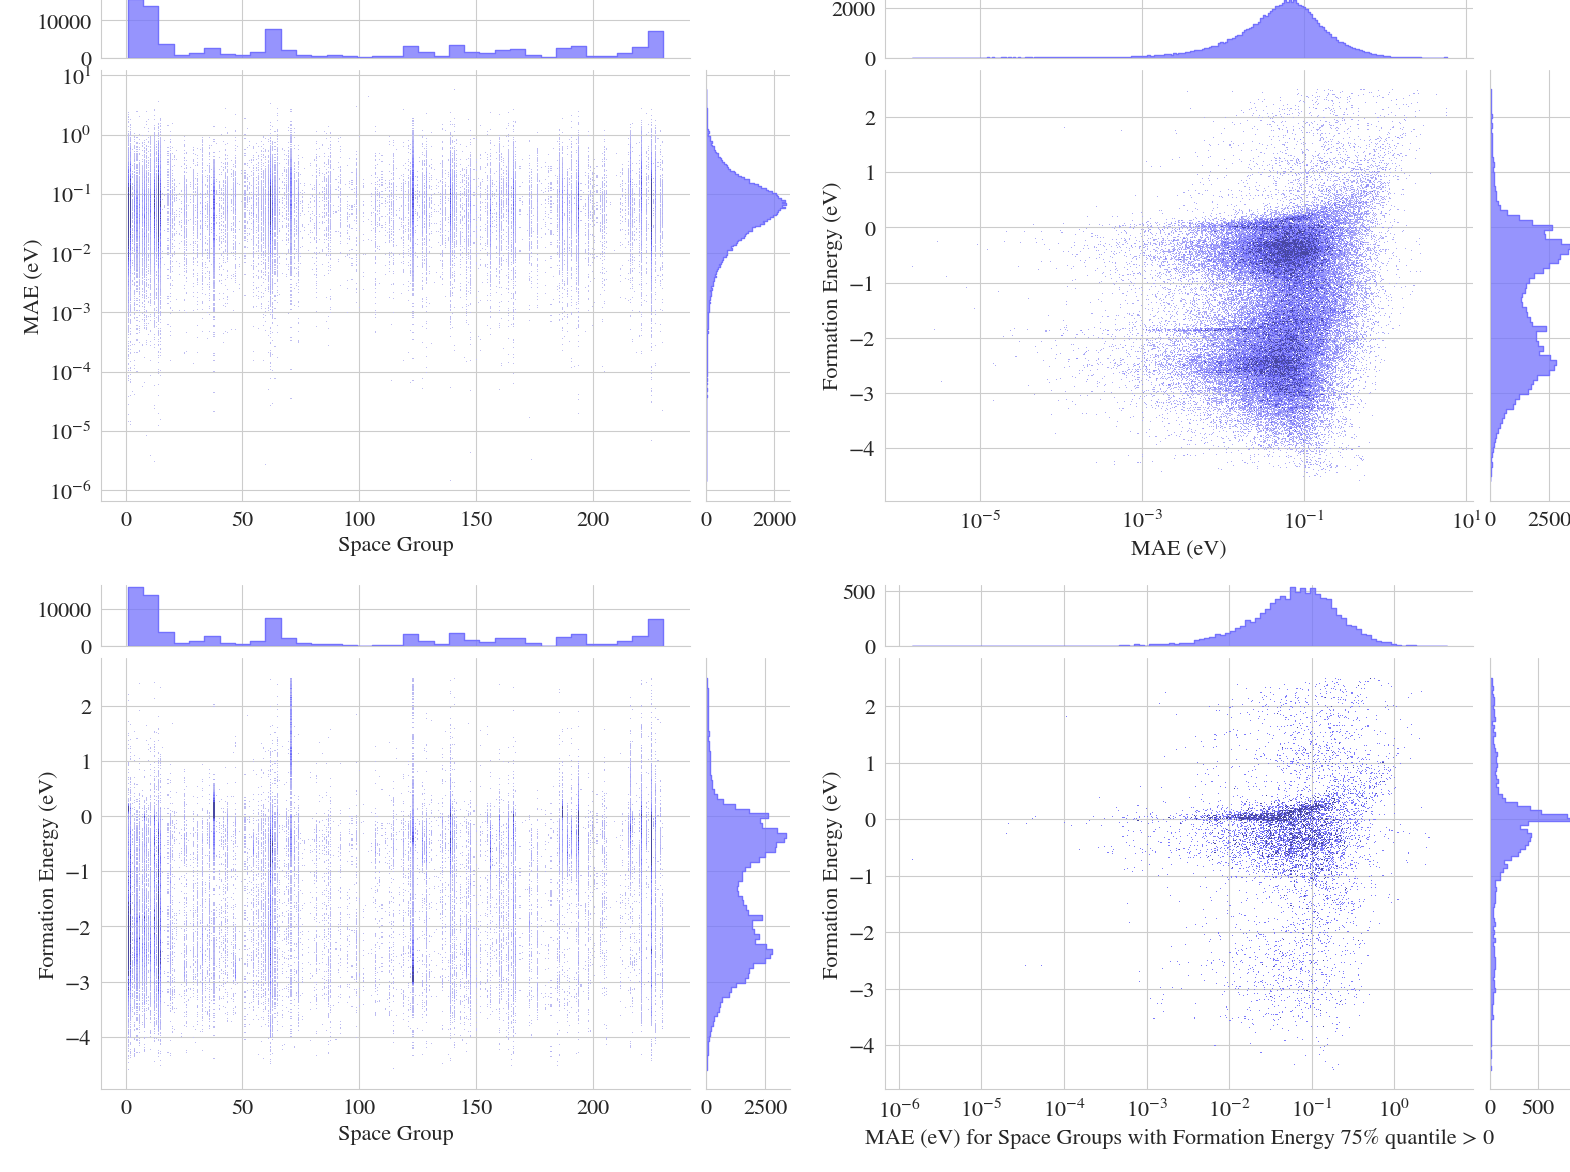

In [40]:
g0 = joint_plot(df, "sg", "mae", scale_kwarg={"yscale": "log"})
g1 = joint_plot(df, "sg", "eform")
g2 = joint_plot(df, "mae", "eform", scale_kwarg={"xscale": "log"})
g3 = joint_plot(
    df[df.sg.isin(sg_pos)],
    "mae",
    "eform",
    scale_kwarg={"xscale": "log"},
    labels={
        "mae": "MAE (eV) for Space Groups with Formation Energy 75% quantile > 0",
        "eform": "Formation Energy (eV)",
        "sg": "Space Group",
    },
)

fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(2, 2)

mg0 = SeabornFig2Grid(g0, fig, gs[0])
mg2 = SeabornFig2Grid(g1, fig, gs[2])

mg1 = SeabornFig2Grid(g2, fig, gs[1])
mg3 = SeabornFig2Grid(g3, fig, gs[3])


gs.tight_layout(fig)
# gs.update(top=0.7)

plt.savefig(op / "mae_eform_jointplot.png", dpi=300)
plt.show()

<Figure size 500x500 with 0 Axes>

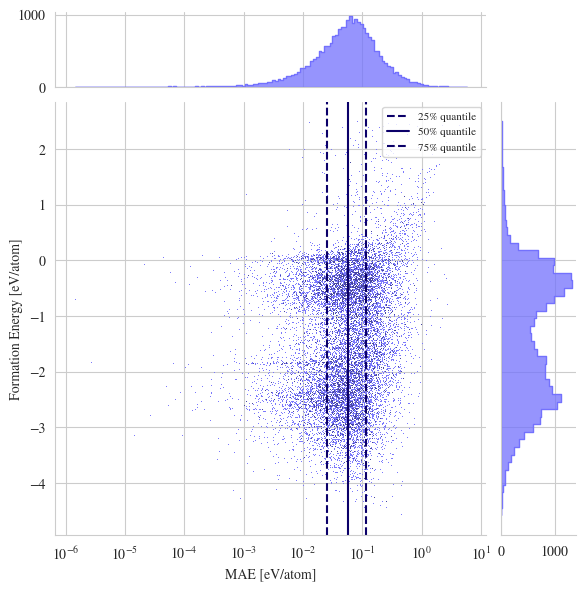

In [41]:

matplotlib.rcParams.update({'font.size': 10})


g = joint_plot(
    df[df.dataset == "val"],
    "mae",
    "eform",
    scale_kwarg={"xscale": "log"},
    labels={
        "mae": "MAE [eV/atom]",
        "eform": "Formation Energy [eV/atom]",
        "sg": "Space Group",
    },
    figsize=(5,5)
)
# plot the 25 / 50 / 75 quantiles in mae error
_m = df[df.dataset == "val"]["mae"]
g.ax_joint.axvline(_m.quantile(0.25), color="#0B0069", linestyle="--", label="25% quantile")
g.ax_joint.axvline(_m.quantile(0.5), color="#0B0069", linestyle="-", label="50% quantile")
g.ax_joint.axvline(_m.quantile(0.75), color="#0B0069", linestyle="--", label="75% quantile")
g.ax_joint.legend(fontsize=8)
plt.savefig(op / "mae_eform_jointplot_val.pdf")
plt.savefig(op / "mae_eform_jointplot_val.png", dpi=250)


In [42]:
model.loaded_config["src"]

'$root/data/matbench_mp_e_form'

In [43]:
df.to_csv("plots/proxy_loss/proxy_loss_eform.csv", index=False)

In [44]:
sorted({194, 228, 38, 71, 104, 139, 216, 187})

[38, 71, 104, 139, 187, 194, 216, 228]

In [45]:
model.loaded_config["model"]

{'num_layers': 5,
 'hidden_channels': 576,
 'sg_emb_size': 128,
 'lat_hidden_channels': 384,
 'lat_num_layers': 1,
 'comp_num_layers': 2,
 'comp_hidden_channels': 196,
 'comp_phys_embeds': {'use': True,
  'z_emb_size': 128,
  'period_emb_size': 256,
  'group_emb_size': 16,
  'properties_proj_size': 64,
  'n_elements': 90}}

In [46]:
model.loaded_config["optim"]

{'batch_size': 448,
 'lr': 0.0017152844503017278,
 'epochs': 100,
 'es_patience': 11,
 'scheduler': {'name': 'ReduceLROnPlateau',
  'patience': 4,
  'step_size': 5000,
  'decay_factor': 0.5},
 'num_workers': 2}

In [47]:
model.loaded_config["run_dir"]

'/network/scratch/s/schmidtv/dave/runs/3667339-20'

In [48]:
ls /network/scratch/s/schmidtv/dave/runs/3667339-20

checkpoints-3435931c/


In [49]:
mae = df[df.dataset == "val"]["mae"]
mae.describe()

count    23232.000000
mean         0.104304
std          0.165569
min          0.000001
25%          0.025467
50%          0.058513
75%          0.116643
max          5.775782
Name: mae, dtype: float64

In [50]:
1.96 * mae.sem()

0.002129074754812132

In [51]:
# https://github.com/marcoalopez/GrainSizeTools/blob/8c6f9e48cc0be3ff4080482739cf0e0f2dccb463/grain_size_tools/averages.py

from scipy.stats import bayes_mvs, gaussian_kde, iqr, t, norm

def critical_t(confidence, sample_size):
    """Returns the (two-tailed) critical value of t-distribution

    Parameters
    ----------
    confidence : float, scalar between 0 and 1
        the level of confidence. E.g. 0.95 -> 95%

    sample_size : scalar, int
        the sample size

    Assumptions
    -----------
    - the population is symmetric
    """

    # recalculate confidence for the two-tailed t-distribution
    confidence = confidence + ((1 - confidence) / 2)

    return t.ppf(confidence, sample_size)

def mCox_ci(data, ci=0.95):
    """ Returns the error margin for the arithmetic mean using the modified
    Cox method. This is a method optimized from lognormal populations. The
    method implemented below uses the Bessel corrected SD as it produces
    safer/robust results for small sample sizes

    Parameters
    ----------
    data : array_like
        the dataset

    ci : float, scalar between 0 and 1
        the confidence interval, default = 0.95

    Reference
    ---------
    Armstrong (1992) https://doi.org/10.1080/15298669291360003
    Lopez-Sanchez (2020) TODO

    Call
    ----
    calc_t

    Returns
    -------
    the lower and upper confidence intervals (tuple)
    the interval length (scalar)
    """

    n = len(data)
    t = critical_t(confidence=ci, sample_size=n)
    data = np.log(data)
    mean_log, std_log = np.mean(data), np.std(data, ddof=1)

    lower = np.exp(mean_log + 0.5
                   * std_log**2 - t
                   * (std_log / np.sqrt(n))
                   * np.sqrt(1 + (std_log**2 * n) / (2 * (n + 1))))
    upper = np.exp(mean_log + 0.5
                   * std_log**2 + t
                   * (std_log / np.sqrt(n))
                   * np.sqrt(1 + (std_log**2 * n) / (2 * (n + 1))))
    interval = upper - lower

    return (lower, upper), interval

print(mCox_ci(mae.values))


((0.11777295593034066, 0.12328508819541052), 0.005512132265069858)
